# CTM MILP Formulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.nophasing import Constraint6Model

## Using the Module

In [2]:
model = Constraint6Model(
    sat_flow_rate=600,
    demand=450,
    time_step=3,
    time_range=60,
    g_min=10,
    g_max=50
)

model.generate()

In [3]:
model._constraints.keys()

['turnratios',
 'greentime',
 'init',
 'flowcon',
 'flowrate',
 'conflicts',
 'greenflowrate']

In [4]:
model.solve(log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 4152 rows and 412 columns.
MIP Presolve modified 1724 coefficients.
Aggregator did 500 substitutions.
Reduced MIP has 6988 rows, 3888 columns, and 31636 nonzeros.
Reduced MIP has 720 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (37.00 ticks)
Found incumbent of value 10980.000000 after 0.08 sec. (94.85 ticks)
Probing time = 0.00 sec. (1.32 ticks)
Tried aggregator 1 time.
MIP Presolve modified 12 coefficients.
Reduced MIP has 6988 rows, 3888 columns, and 31636 nonzeros.
Reduced MIP has 720 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (21.16 ticks)
Probing time = 0.00 sec. (1.32 ticks)
Clique table members: 480.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.71 sec. (490.78 ticks)

        Nodes    

37.61031198501587

## Showing the Cell Capacities

In [5]:
df_x, df_y, df_g = model.return_solution()

In [6]:
df_x_source = df_x[df_x.cell == (CELL_SOURCE,0,1)].sort_values(by='timestep')
df_x_normal0 = df_x[df_x.cell == (CELL_NORMAL,0,1)].sort_values(by='timestep')
df_x_normal1 = df_x[df_x.cell == (CELL_NORMAL,1,1)].sort_values(by='timestep')
df_x_normal2 = df_x[df_x.cell == (CELL_NORMAL,2,1)].sort_values(by='timestep')
df_x_left = df_x[df_x.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_x_sink = df_x[df_x.cell == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].sort_values(by='timestep')

df_x_approach = df_x_source.append(df_x_normal1).append(df_x_normal2).append(df_x_normal0).append(df_x_left).append(df_x_sink)
df_x_approach = df_x_approach.pivot(index='timestep', columns='cell', values='volume')
df_x_approach

cell,"(0, 0, 1)","(1, 0, 3)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,,
0,1.50,0.000,0.000000,0.00,0.00,0.000000
1,1.50,0.000,0.000000,1.50,0.00,0.000000
2,2.00,0.000,0.000000,1.00,1.50,0.000000
3,1.50,0.000,0.000000,2.00,1.00,1.500000
4,1.50,0.000,1.000000,1.50,2.00,1.250000
5,1.50,0.125,2.000000,1.50,2.25,1.250000
6,1.50,0.125,3.000000,2.00,2.00,1.250000
7,1.50,0.125,4.000000,2.00,1.50,2.000000
8,2.00,0.125,5.000000,1.00,2.00,2.250000


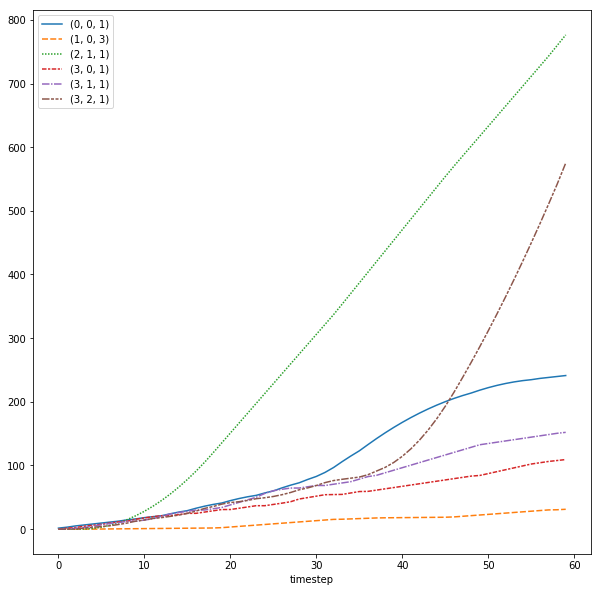

In [7]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_x_approach.cumsum())

This linear, cascading cumulative sum of consecutive cells (except for the through cell) means that the turning ratio is working fine.

In [8]:
df_y_source = df_y[df_y.cell_from == (CELL_SOURCE,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal0 = df_y[df_y.cell_from == (CELL_NORMAL,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal1 = df_y[df_y.cell_from == (CELL_NORMAL,1,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_left = df_y[df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_sink = df_y[df_y.cell_from == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_approach = df_y_source.append(df_y_normal1).append(df_y_normal2).append(df_y_normal0).append(df_y_left).append(df_y_sink)
df_y_approach.reset_index(inplace=True)
df_y_approach = df_y_approach.pivot(index='timestep', columns='cell_from', values='flow')
df_y_approach

cell_from,"(0, 0, 1)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,
0,1.50,0.0,0.00,0.000000,0.000000
1,1.00,0.0,1.50,0.000000,0.000000
2,2.00,0.0,1.00,1.500000,0.000000
3,1.50,0.0,2.00,1.000000,1.250000
4,1.50,0.0,1.50,1.250000,1.250000
5,1.50,0.0,1.00,1.250000,1.250000
6,1.50,0.0,1.50,2.000000,1.250000
7,1.00,0.0,2.00,1.500000,1.250000
8,2.00,0.0,0.00,2.000000,1.250000


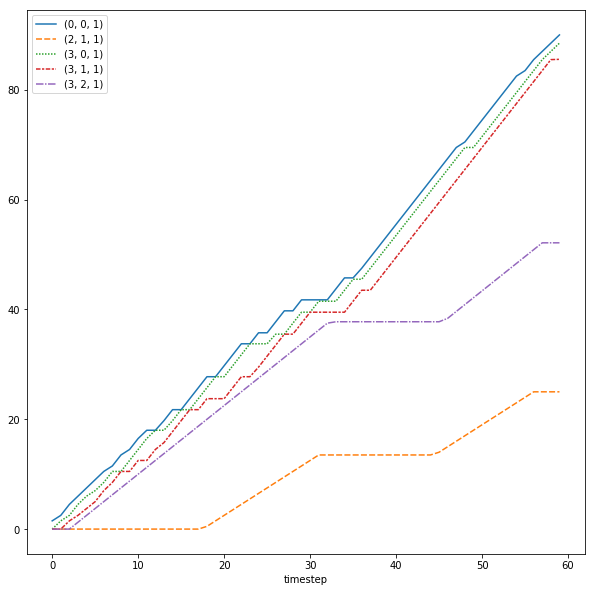

In [9]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_y_approach.cumsum())

### Comparing the Green Signal and the Flow

In [10]:
df_g_specific = df_g[df_g.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_y_specific = df_y[(df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)) & (df_y.cell_to == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0])].sort_values(by='timestep')
df_y_specific = df_y_specific.groupby(['timestep', 'cell_from']).agg({'flow': 'sum'}).reset_index()

df_g_y = pd.merge(df_g_specific, df_y_specific, left_on=['timestep', 'cell'], right_on=['timestep', 'cell_from'])[
    ['timestep', 'is_green', 'flow']
]

df_g_y.set_index('timestep', inplace=True)

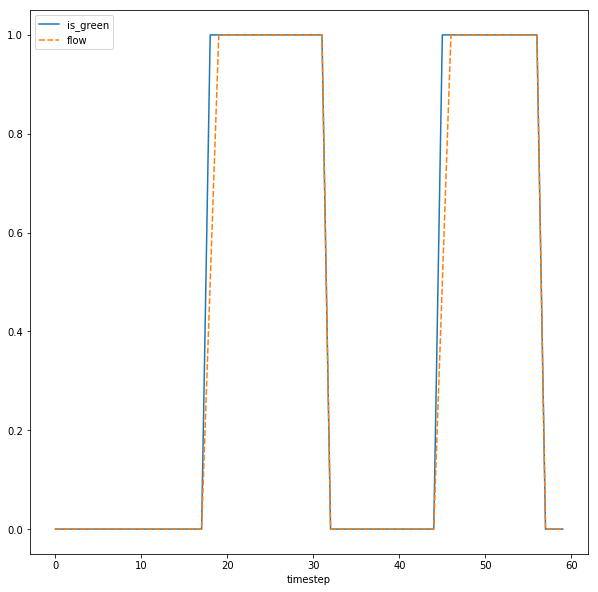

In [11]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_g_y)

### Checking the Greentimes of the 12 stoplights

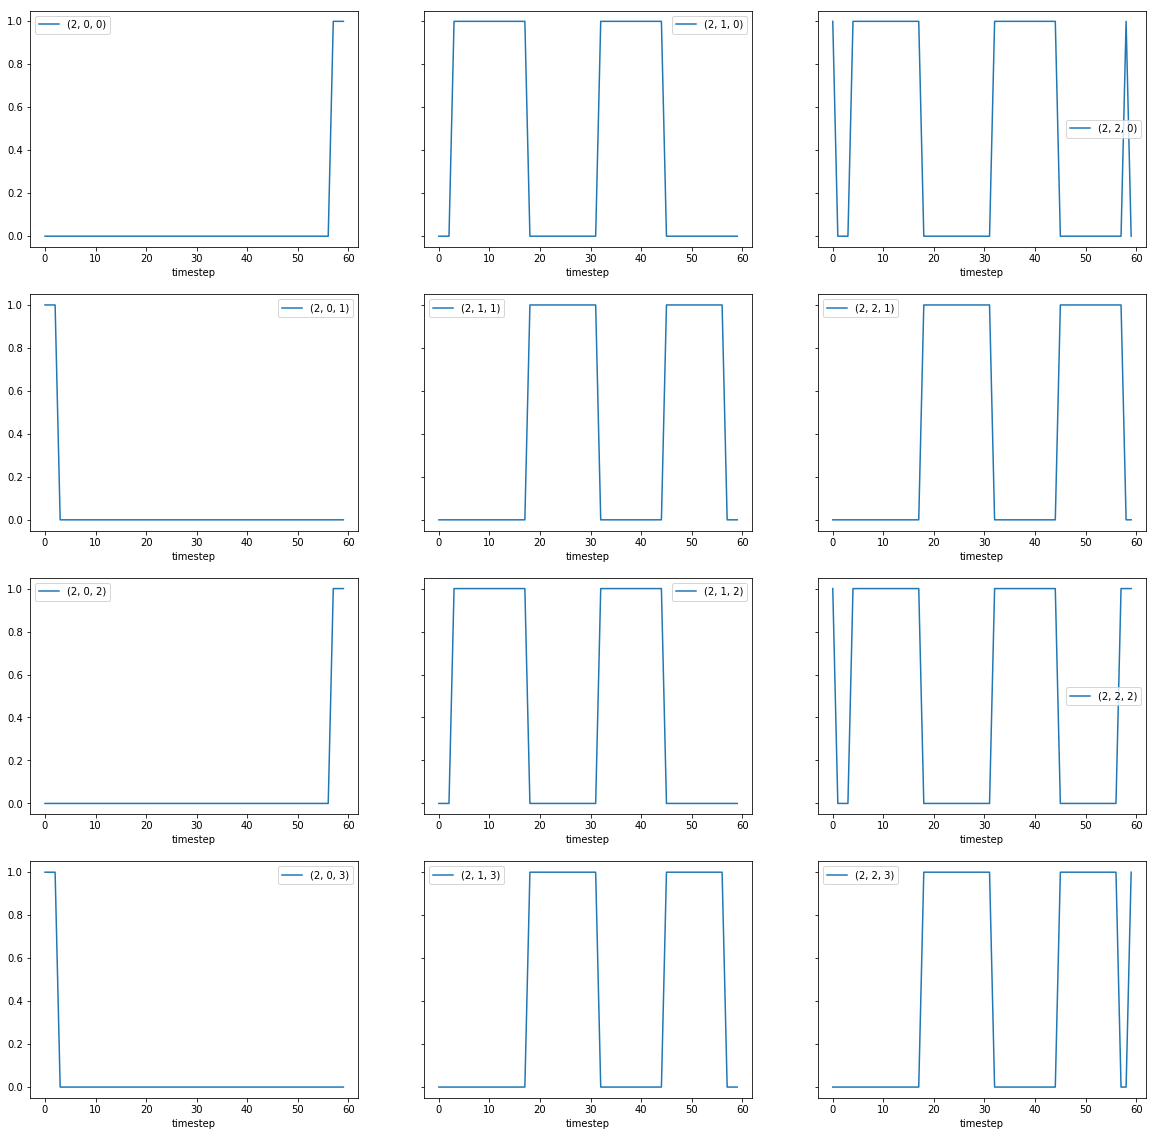

In [12]:
df_g_map = df_g.pivot(index='timestep', columns='cell', values='is_green')
approaches = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

_, axs = plt.subplots(4,3,figsize=(20,20), sharey=True)

for i in range(4):
    for j in range(3):
         sns.lineplot(data=df_g_map[[approaches[i][j]]], ax=axs[i][j])


In [86]:
# Save your shit
df_x.to_pickle('x.pkl')
df_y.to_pickle('y.pkl')
df_g.to_pickle('g.pkl')